In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install torch torchvision

In [ ]:
from PIL import Image

# Load an example image from your dataset
image_path = '/content/drive/My Drive/nndlprojectdata/pRCC/train/3610_6089_2000.jpg'
img = Image.open(image_path)

# Get the dimensions of the image
width, height = img.size
print(f"Image dimensions: {width} x {height}")

Image dimensions: 2000 x 2000


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# Check for GPU availability and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define a custom autoencoder class with Kaiming (He) initialization and a more complex architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
        self._initialize_weights()  # Apply Kaiming initialization

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Set the paths to your data
data_dir = '/content/drive/My Drive/nndlprojectdata/pRCC/train'
val_dir = '/content/drive/My Drive/nndlprojectdata/pRCC/validation'
input_shape = (3, 2000, 2000)  # Channels, Height, Width

# Set hyperparameters
batch_size = 4
epochs = 10

# Create the autoencoder model and move it to the GPU
autoencoder = Autoencoder()
autoencoder.to(device)

# Loss function and optimizer with L2 regularization
criterion = nn.MSELoss()
weight_decay = 1e-5  # L2 regularization strength
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=weight_decay)

# Learning rate reduction on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, min_lr=0.00001)

# Create a custom dataset and data loader for unlabeled data (without classes)
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = os.listdir(data_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

# Transformation for both training and validation data
transform = transforms.Compose([transforms.Resize((2000, 2000)), transforms.ToTensor()])

# Create data loaders for training and validation and move data to the GPU
train_dataset = CustomDataset(data_dir, transform=transform)
val_dataset = CustomDataset(val_dir, transform=transform)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

training_losses,validation_losses=[],[]

# Training loop with learning rate reduction on plateau
for epoch in range(epochs):
    running_loss = 0.0
    autoencoder.train()
    for i, data in enumerate(train_data_loader, 0):
        data = data.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = autoencoder(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_data_loader, 0):
            data = data.to(device)  # Move data to GPU
            outputs = autoencoder(data)
            loss = criterion(outputs, data)
            val_loss += loss.item()
    training_losses.append(running_loss / len(train_data_loader))
    validation_losses.append(val_loss / len(val_data_loader))
    print(f'Epoch {epoch + 1}: Training Loss = {running_loss / len(train_data_loader)}, Validation Loss = {val_loss / len(val_data_loader)}')

    # Update the learning rate using the scheduler based on validation loss
    scheduler.step(val_loss)

print('Finished Training')


Epoch 1: Training Loss = 0.01852617906582243, Validation Loss = 0.006279560944272412
Epoch 2: Training Loss = 0.005249761403450426, Validation Loss = 0.003979273366793577
Epoch 3: Training Loss = 0.0040772037668469945, Validation Loss = 0.0035213394827830293
Epoch 4: Training Loss = 0.0037892421074914484, Validation Loss = 0.003290762588019586
Epoch 5: Training Loss = 0.0035934091870725715, Validation Loss = 0.003104391979933199
Epoch 6: Training Loss = 0.0033795464942056055, Validation Loss = 0.003030605313445752
Epoch 7: Training Loss = 0.0033206810700302978, Validation Loss = 0.002969572624553823
Epoch 8: Training Loss = 0.0031336874266172637, Validation Loss = 0.0028352606006794507
Epoch 9: Training Loss = 0.0030147034652917735, Validation Loss = 0.0026329225899341204
Epoch 10: Training Loss = 0.002986358865691384, Validation Loss = 0.00264224638360449
Finished Training


In [ ]:
torch.save(autoencoder.state_dict(), '/content/drive/My Drive/nndlprojectdata/pRCC/autoencoder_model_complex.pth')

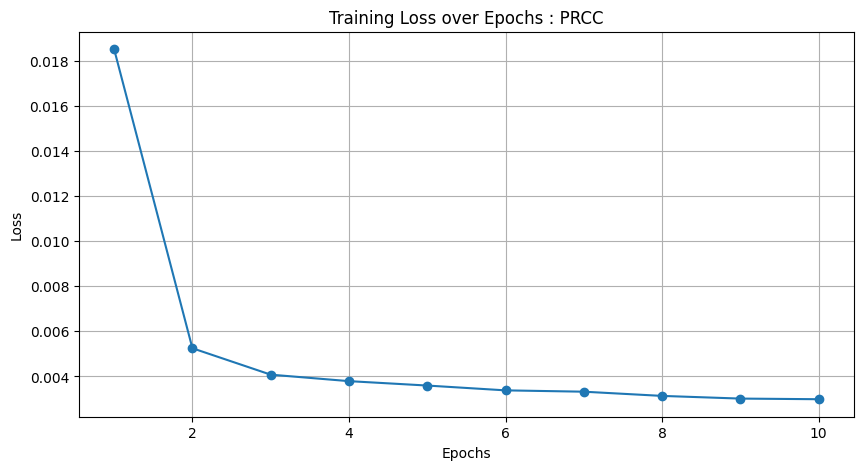

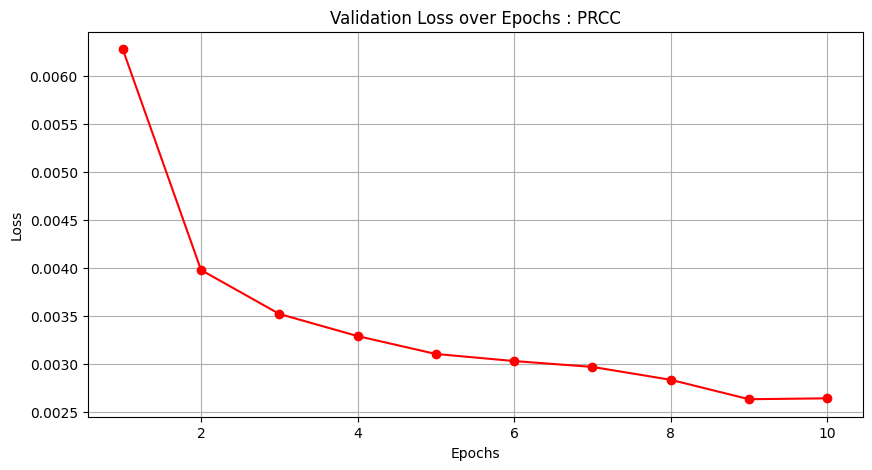

In [ ]:
import matplotlib.pyplot as plt

# Create a list of epoch numbers
epochs = range(1, len(training_losses) + 1)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label='Training Loss', marker='o')
plt.title('Training Loss over Epochs : PRCC')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, validation_losses, label='Validation Loss', marker='o',color='red')
plt.title('Validation Loss over Epochs : PRCC')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the trained autoencoder model
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load('/content/drive/My Drive/nndlprojectdata/pRCC/autoencoder_model_complex.pth'))
autoencoder.eval()

# Load the input image you want to reconstruct
input_image_path = '/content/drive/My Drive/nndlprojectdata/pRCC/test/26829_22609_2000.jpg'
input_image = Image.open(input_image_path)

# Define a transform to preprocess the input image
transform = transforms.Compose([transforms.Resize((2000, 2000)), transforms.ToTensor()])

# Preprocess the input image
input_tensor = transform(input_image).unsqueeze(0)  # Add a batch dimension

# Pass the input tensor through the autoencoder
output_tensor = autoencoder(input_tensor)

# Extract the output image tensor
reconstructed_image = output_tensor.squeeze(0).detach().cpu().numpy()

# Convert the output tensor back to an image
reconstructed_image = (reconstructed_image * 255).astype('uint8')
reconstructed_image = Image.fromarray(reconstructed_image.transpose(1, 2, 0), 'RGB')

# Save or display the reconstructed image
reconstructed_image.save('/content/drive/My Drive/nndlprojectdata/pRCC/complex_reconstructed_image.jpg')
reconstructed_image.show()


**Testing on a Test Input Image**

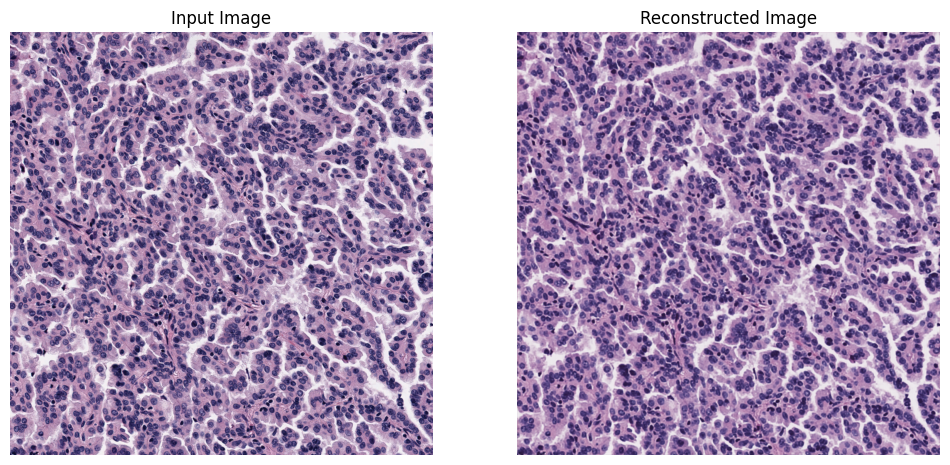

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Input Image')
axes[0].imshow(input_image)
axes[0].axis('off')
axes[1].set_title('Reconstructed Image')
axes[1].imshow(reconstructed_image)
axes[1].axis('off')
plt.show()